<a href="https://colab.research.google.com/github/OsyaginVictor/Choosing-the-location-/blob/main/Choosing_the_location_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [ ]:
#импортируем необходимые библиотеки и инструменты
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [ ]:
#загрузим данные о трех регионах
oil_well_1 = pd.read_csv('/datasets/geo_data_0.csv')
oil_well_2 = pd.read_csv('/datasets/geo_data_1.csv')
oil_well_3 = pd.read_csv('/datasets/geo_data_2.csv')

Ознакомимся с данными и выявим взаимосвязь между признаками.

(100000, 5)

      id        f0        f1        f2     product
0  txEyH  0.705745 -0.497823  1.221170  105.280062
1  2acmU  1.334711 -0.340164  4.365080   73.037750
2  409Wp  1.022732  0.151990  1.419926   85.265647
3  iJLyR -0.032172  0.139033  2.978566  168.620776
4  Xdl7t  1.988431  0.155413  4.751769  154.036647



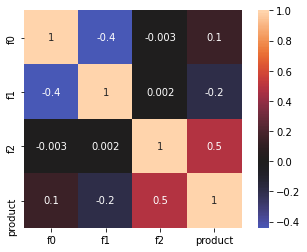

In [ ]:
print(oil_well_1.shape)
print()
print(oil_well_1.head())
print()
sns.heatmap(oil_well_1.corr(), annot=True, square=True, center=0, fmt='.1g');

(100000, 5)

      id         f0         f1        f2     product
0  kBEdx -15.001348  -8.276000 -0.005876    3.179103
1  62mP7  14.272088  -3.475083  0.999183   26.953261
2  vyE1P   6.263187  -5.948386  5.001160  134.766305
3  KcrkZ -13.081196 -11.506057  4.999415  137.945408
4  AHL4O  12.702195  -8.147433  5.004363  134.766305



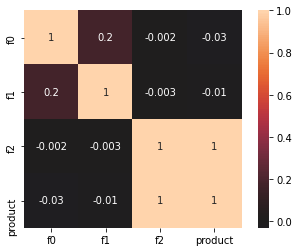

In [ ]:
print(oil_well_2.shape)
print()
print(oil_well_2.head())
print()
sns.heatmap(oil_well_2.corr(), annot=True, square=True, center=0, fmt='.1g');

(100000, 5)

      id        f0        f1        f2     product
0  fwXo0 -1.146987  0.963328 -0.828965   27.758673
1  WJtFt  0.262778  0.269839 -2.530187   56.069697
2  ovLUW  0.194587  0.289035 -5.586433   62.871910
3  q6cA6  2.236060 -0.553760  0.930038  114.572842
4  WPMUX -0.515993  1.716266  5.899011  149.600746



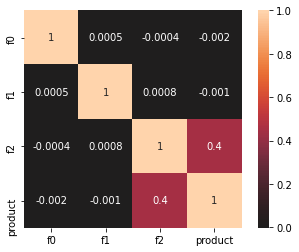

In [ ]:
print(oil_well_3.shape)
print()
print(oil_well_3.head())
print()
sns.heatmap(oil_well_3.corr(), annot=True, square=True, center=0, fmt='.1g');

Показатели корреляции регионов 1 и 3 похожи, сильной корреляции данных нет, больше всего зависит целевой признак product от признака f2. А в регионе 2 заметна неправдоподобная взаимосвязь этих двух признаков, единица. Это может быть связано с тем, что данные синтетические, в реальной жизни такой коэффициент корреляции сложно представить.

Проверим данные на полные дубликаты.

In [ ]:
print(oil_well_1.duplicated().value_counts())
print(oil_well_2.duplicated().value_counts())
print(oil_well_3.duplicated().value_counts())

False    100000
dtype: int64
False    100000
dtype: int64
False    100000
dtype: int64


Дублирующихся данных нет - это хорошо, но стоит проверить, нет ли разных данных об одной и той же скважине.

In [ ]:
print(oil_well_1['id'].value_counts().head())
print(oil_well_2['id'].value_counts().head())
print(oil_well_3['id'].value_counts().head())

fiKDv    2
74z30    2
Tdehs    2
bxg6G    2
HZww2    2
Name: id, dtype: int64
5ltQ6    2
bfPNe    2
LHZR0    2
wt4Uk    2
7TMdL    1
Name: id, dtype: int64
VF7Jo    2
KUPhW    2
Vcm5J    2
xCHr8    2
OwFH1    1
Name: id, dtype: int64


In [ ]:
print(oil_well_1.query('id == "HZww2"'))
print()
print(oil_well_2.query('id == "bfPNe"'))

         id        f0        f1         f2     product
931   HZww2  0.755284  0.368511   1.863211   30.681774
7530  HZww2  1.061194 -0.373969  10.430210  158.828695

          id        f0        f1        f2     product
2721   bfPNe -9.494442 -5.463692  4.006042  110.992147
82178  bfPNe -6.202799 -4.820045  2.995107   84.038886


В датасетах есть сведения о скважинах с одинаковыми именами, но разными признаками. Таких дублирующихся скважин немного, но они подозрительны. Удалим их, оставив только уникальные. На качество модели удаление такого небольшого количества данных повлиять не должно.

In [ ]:
#напишем функцию для удаления наблюдений с дублирующимися id, которая на вход будет принимать название датасета
def remove_double (data):
    names = data['id'].value_counts().reset_index()
    unique_names = names.query('id == 1')['index'].to_list()
    data.query('id in @unique_names', inplace=True)


Применим функцию ко всем трем датасетам и проверим, как изменилось их наполнение.

In [ ]:
remove_double(oil_well_1)
print(oil_well_1.shape)
remove_double(oil_well_2)
print(oil_well_2.shape)
remove_double(oil_well_3)
print(oil_well_3.shape)

(99980, 5)
(99992, 5)
(99992, 5)


Вывод:

импортировали все необходимые инструменты,
загрузили датасеты и ознакомились с ними,
выявили подозрительную особенность - во всех трех датасетах имеются наблюдения о скважинах с одинаковым именем, но разными значениями признаков,
избавились от наблюдений с дублирующимися именами с помощью функции remove_double
проверили коэффициент корреляции - показатели корреляции регионов 1 и 3 похожи, сильной корреляции данных нет, больше всего зависит целевой признак product от признака f2. В регионе 2 заметна неправдоподобная взаимосвязь этих двух признаков, почти единица. Это может быть связано с тем, что данные синтетические

## Обучение и проверка модели

In [ ]:
model = LinearRegression()

Напишем функцию get_predictions, которая разобьет данные на обучающую и валидационную выборки в соотношении 75:25, а затем обучит модель и сделает предсказания на валидационной выборке.

In [ ]:
def get_predictions_target (data):
    features = data.drop(['id', 'product'], axis = 1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=.25, random_state=666)
    model.fit(features_train, target_train)
    return pd.Series(model.predict(features_valid)), target_valid

Сохраним предсказания и правильные ответы.

In [ ]:
predicted_1, target_1 = get_predictions_target(oil_well_1)

In [ ]:
predicted_2, target_2 = get_predictions_target(oil_well_2)

In [ ]:
predicted_3, target_3 = get_predictions_target(oil_well_3)

Посмотрим на средний запас предсказанного сырья для каждого региона и RMSE (корень от среднеквадратичной ошибки) модели. Тем самым мы проверим модели на адекватность.

In [ ]:
def get_mean_product_and_rmse (answers, predictions):
    mse = mean_squared_error(answers, predictions)
    print('Средний запас сырья, тыс. баррелей:', predictions.mean())
    print('RMSE:', mse ** 0.5)

In [ ]:
print('Регион №1')
print()
get_mean_product_and_rmse(target_1, predicted_1)

Регион №1

Средний запас сырья, тыс. баррелей: 92.51122396649593
RMSE: 37.51264378666752


In [ ]:
print('Регион №2')
print()
get_mean_product_and_rmse(target_2, predicted_2)

Регион №2

Средний запас сырья, тыс. баррелей: 68.84582277575738
RMSE: 0.889353331828901


In [ ]:
print('Регион №3')
print()
get_mean_product_and_rmse(target_3, predicted_3)

Регион №3

Средний запас сырья, тыс. баррелей: 95.1896200039048
RMSE: 40.00784454122081


Вывод:

разбили данные на обучающую и валидационную выборки
обучили модели и сделали предсказания, сохранили их и правильные ответы
посчитали средний запас сырья для каждого региона по предсказаниям и RMSE
качественнее всего модель отработала для региона №2, здесь метрика RMSE с самым маленьким значением - наверняка так влияет большой коэффициент корреляции между одним из признаков и целевым признаком
средний предсказанный запас сырья больше всего у регионов 1 и 3, больше 90 тыс. бареллей. Здесь же значение RMSE получилось очень большим, почти половина этого числа

## Подготовка к расчёту прибыли

In [ ]:
#бюджет на разработку скважин в одном регионе в рублях
BUDGET = 10000000000

#количество скважин для бурения
OIL_WELLS_NUMBER = 200

#бюджет на одну скважину
BUDGET_FOR_ONE = BUDGET / OIL_WELLS_NUMBER

#доход с одной единицы продукта в рублях
REVENUE_RUB = 450000

#максимальная доля убытков
MAX_RISK = 0.025

#рублей в млрд
MLRD = 1000000000

Чтобы проект был прибыльным, посчитаем минимальное среднее количество продукта в месторождениях региона, достаточное для разработки.

In [ ]:
BUDGET_FOR_ONE / REVENUE_RUB

111.11111111111111

In [ ]:
print("Средний истинный запас сырья в регионах, тыс. баррелей:")
print()
print("Регион 1:", target_1.mean())
print("Регион 2:", target_2.mean())
print("Регион 3:", target_3.mean())

Средний истинный запас сырья в регионах, тыс. баррелей:

Регион 1: 92.3858860901055
Регион 2: 68.83866771152616
Регион 3: 94.7475498366247


Грубо говоря, 111.2 единицы продукта в одной скважине - это минимальный объем сырья, при котором проект не станет убыточным. Если сравнивать со средним истинным объемом сырья, который мы посчитали в предыдущем шаге, то проект будет убыточным в любом регионе. Но мы будем исследовать только 500 скважин, из которых выберем 200 самых прибыльных.

Напишем функцию рассчета прибыли по 200 скважинам каждого региона, из которых получается самый большой объем сырья.

In [ ]:
def revenue(target, probabilities):
    target = pd.Series(target).reset_index(drop=True)
    probabilities = pd.Series(probabilities).reset_index(drop=True)
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:OIL_WELLS_NUMBER]
    return ((REVENUE_RUB * selected.sum()) - BUDGET) / MLRD

In [ ]:
revenue(target_1, predicted_1)

3.1361591450086554

In [ ]:
revenue(target_2, predicted_2)

2.4150866966815108

In [ ]:
revenue(target_3, predicted_3)

2.1309791872583483

На данном этапе, судя из рассчетов, самым прибыльным является регион 1 - выручка здесь больше 3-х млрд рублей.

## Расчёт прибыли и рисков

Посчитаем риски и прибыль для всех трех регионов с помощью процедуры Bootstrap.

In [ ]:
state = np.random.RandomState(666)

In [ ]:
def bootstrap (target, predictions):
    values = []
    for i in range(1000):
        target_subsample = target.reset_index(drop=True).sample(n=500, replace=True, random_state=state)
        probs_subsample = predictions[target_subsample.index]
        rev = revenue(target_subsample, probs_subsample)
        values.append(rev)

    values = pd.Series(values)
    lower = values.quantile(MAX_RISK)
    confidence_interval = st.t.interval(0.95, len(values)-1, values.mean(), values.sem())
    mean = values.mean()

    print("Средняя выручка:", mean)
    print("2.5%-квантиль:", lower)
    print("Доверительный интервал:", confidence_interval)
    print("Риски убытка:", (values < 0).mean())

In [ ]:
bootstrap(target_1, predicted_1)

Средняя выручка: 0.41479958161807007
2.5%-квантиль: -0.08099655547090868
Доверительный интервал: (0.39865380846626214, 0.430945354769878)
Риски убытка: 0.048


In [ ]:
bootstrap(target_2, predicted_2)

Средняя выручка: 0.42736389192366653
2.5%-квантиль: 0.007483545047568657
Доверительный интервал: (0.4143367855164308, 0.4403909983309023)
Риски убытка: 0.022


In [ ]:
bootstrap(target_3, predicted_3)

Средняя выручка: 0.33012128371491745
2.5%-квантиль: -0.21131634368174967
Доверительный интервал: (0.3130545585390611, 0.3471880088907738)
Риски убытка: 0.122


Из всех трех регионов по уровню риска проходит только регион №2. К тому же, добыча здесь принесёт наибольшую прибыль.

Вывод: Для реализации проекта больше всего подходит регион 2. Бурение скважин здесь связанно с наименьшими рисками и принесет бОльшую выручку.